<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0820_pyTorch(LSTM%2C%20GRU%2C%20BERT)/pyTorch(BERT_IMAGE_StyleTransfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT학습
- 자연어 전처리
- RNN -> LSTM -> 어텐션 -> transformer() : BERT(전이학습할 구현체(프레임워크))

## Generative Model(생성 모델) - 비지도 학습
- Auto Encoder -> GAN



## 1.Style Transfer란?
- 다른 이미지의 스타일을 학습시켜 현재 이미지에 스타일을 적용시키는 것
- 직접 만들지 않고 전이 학습으로 구현하는 경우가 대부분
- 여기서 사용하는 모델은 주로 이미지넷 구분 작업에 사용한 모델들인데 이 모델들은 이미지에서 특정한 형태를 구분하는 필터를 가지고 있습니다.

- 논문에서는 스타일을 다른 필터 응답들 값의 연관성(correlations between the different filter responses)이라고 서술하며 이에 덧붙여 필터 확성도의 그람 행렬로 나타냈는데 그람행렬은 벡터가 만들 수 있는 모든 내적을 행렬 곱으로 한번에 만듦

- 왼쪽이 스타일, 가운데가 학습대상의 이미지, 오른쪽이 컨텐츠
- 손실은 가중치를 곱해서 합한 값


## 2.공통 처리

### 1) 필요한 라이브러리 import


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils as utils 
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### 2) 하이퍼파라미터 설정

In [ ]:
# 콘텐츠 손실을 어느 지점에서 맞출 것인지에 대한 지점
content_layer_num = 1 
# 이미지 크기
image_size = 512
epoch = 5000

### 3) 이미지 경로 설정
- 이미지는 스타일용과 훈련대상 두가지로 크기가 같아야 함

In [ ]:
content_dir = '/content/drive/MyDrive/Colab Notebooks/data/Tuebingen_Neckarfront.jpg'
style_dir = '/content/drive/MyDrive/Colab Notebooks/data/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

### 4) 이미지 전처리 함수
- ResNet(512크기의 이미지를 사용)에 맞도록 전처리해주는 함수

In [ ]:
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(), # 텐서로 변환
            # mean의 수치는 0.5면 대충 적당
            transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961],
                                std = [1, 1, 1])
    ])
    img = transform(img).view((-1, 3, image_size, image_size))
    return img

### 5) 이미지 후 처리 함수
- 전처리된 이미지를 원래의 값으로 되돌리는 함수

In [ ]:
def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],
                                std = [1, 1, 1])
    img = transform(tensor.clone()) # tensor를 복사
    # min 혹은 max의 범주에 해당하도록 값을 변경하는 것
    img = img.clamp(0, 1) 
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    return img

### 6) 디바이스(GPU)설정

In [ ]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print('My Torch Version : ', torch.__version__, 'DEVICE : ', DEVICE)

My Torch Version :  1.9.0+cu102 DEVICE :  cuda


## 3.기존의 resnet모델을 이용하여 새로운 모델 생성

### 1) 학습된 모델 가져오기

```
conv1 - layer
bn1 배치 정규화
relu 활성화 함수
maxpool 
layer1 layer
layer2 - layer
layer3 - layer
layer4 - layer
avgpool
fc : layer. fully connected
```

In [ ]:
resnet = models.resnet50(pretrained=True)
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### 2) 모델 설계
- layer는 conv1, layer1, layer2, layer3, layer4, fc
- layer1에 bn1, relu, maxpool이 설정 됨
- fc에 avgpool이 설정됨


In [ ]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        # resnet의 레이어마다의 결과값을 가져오도록 설정
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1]) # conv1
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4]) # bn1, relu, maxpool, layer1
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5]) # layer2
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6]) # layer3
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7]) # layer4
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8]) # avgpool, fc

    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

## 4.그람 행렬화 와 손실을 계산하는 클래스 생성

In [ ]:
# 그람 행렬화
class GramMatrix(nn.Module) :
    def forward(self, input):
        # 입력 텐서의 값을 분해해서 저장
        b, c, h, w = input.size()
        # 4차원 tensor를 3차원으로 변환
        F = input.view(b, c, h * w)
        # 행렬 곱. 전치 행렬과 내적을 구해서 더함
        G = torch.bmm(F, F.transpose(1, 2))
        return G

# 손실 구하기
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        # 그람 행렬과 타겟의 평균제곱차를 구해 손실 구하기
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

## 5.기존 모델의 파라미터를 변경하지 않도록 설정
- 이 모델의 파라미터는 학습을 해서 변경할 대상이 아니므로
- 이 처리는 매우 많이 쓰이므로 꼭 알아 두어야합니다


### 🚩주의 : resnet모델 재훈련 여부 설정
- resnet 모델은 이미지넷을 이용하여 훈련되었습니다.
- resnet 모델을 이용해서 분류 작업을 하는 것이라면 resnet 모델을 재훈련시키기 위해 requires_grad를 True로 설정해야 합니다
- 하지만 이번엔 분류작업이 아니므로 False를 설정합니다

In [ ]:
resnet = Resnet().to(DEVICE)

for param in resnet.parameters():
    # 이전 모델을 훈련시킨다면 True설정
    # 그렇지 않으면 False를 설정함
    param.requires_grad = False

## 6.컨텐츠/ 스타일/  이미지 설정

In [ ]:
content = image_preprocess(content_dir).to(DEVICE) # 컨텐츠
style = image_preprocess(style_dir).to(DEVICE) # 스타일
generated = content.clone().requires_grad_().to(DEVICE) # 학습의 대상이 되는 이미지

### 2) 컨텐츠/ 스타일/  이미지의 시각화

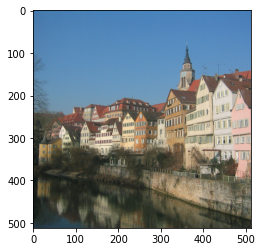

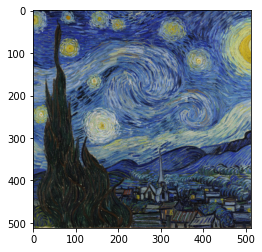

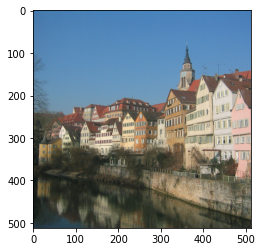

In [ ]:
plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)

plt.show()


## 목표값을 설정하고 행렬의 크기에 따른 가중치 정의
- 가중치는 layer수만큼 6개를 설정합니다.
- 가중치를 설정할 때는 특별한 경우가 아니라면 8의 배수로 설정합니다.

In [ ]:
style_target = list(GramMatrix().to(DEVICE)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
# 가중치 설정 - 앞의 레이어 개수 만큼 설정해야 함
# 통상적으로 8의 배수를 설정합니다.
style_weight = [1/n ** 2 for n in [64,64,256,512,1024,2048]]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


##  모델 훈련
- 스타일 전이에서는 LBFGS최적화 함수를 이용합니다.
- 학습의 대상은 이미지 입니다.

🎈clouser()의 활용은 알아둘 것

In [ ]:
optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        # 스타일의 손실을 계산
        style_loss = [GramMSELoss().to(DEVICE)(out[i],
                    style_target[i]) * style_weight[i]
                    for i in range(len(style_target))]
        # 컨텐츠 손실 계산
        content_loss = nn.MSELoss().to(DEVICE)(out[content_layer_num],
                                               content_target)
        
        # 실제 손실 계산 - style_loss와 content_loss 비율을 설정
        # 나중에 이 비율은 바꿔도 됩니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()
        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)
        

tensor(1507036.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.5276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1932, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2743, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1744, device='cuda:0', grad_fn=<

## 결과 확인
- 결과는 GAN이미지를 확인하면 됩니다.
- 이미지를 출력할 때는 numpy로 변환시킵니다

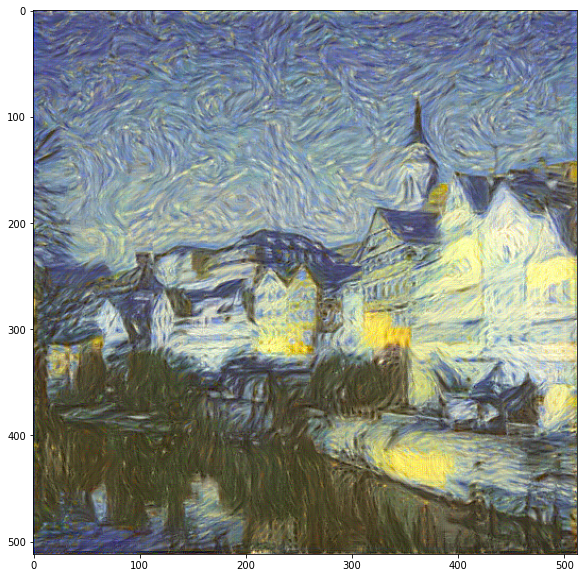

In [ ]:
gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(gen_img)
plt.show()